# Imports y configuracion base

In [12]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# main
def main():
    basePath = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"
    
    if not os.path.exists(basePath):
        print("Dataset no encontrado. Agrega 'Chest X-Ray Pneumonia' como input dataset en Kaggle.")
        return
    
    print("Dataset detectado correctamente en Kaggle.")

if __name__ == "__main__":
    main()

Dataset detectado correctamente en Kaggle.


# Preparacion de los datos

Creando generadores de datos...
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Generadores creados correctamente.
Clases detectadas: {'NORMAL': 0, 'PNEUMONIA': 1}

Muestra aleatoria del conjunto de entrenamiento:


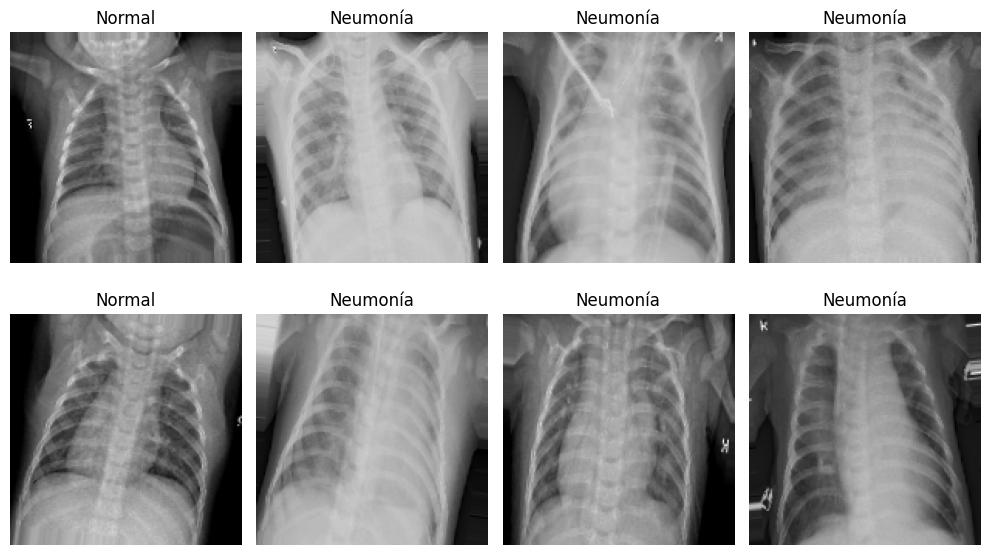

In [13]:
# DataGenerator con augment
def createDataGenerators(basePath, imgSize=(150, 150), batchSize=32):
    trainDir = os.path.join(basePath, "train")
    valDir = os.path.join(basePath, "val")
    testDir = os.path.join(basePath, "test")

    # Aumento de datos para entrenamiento
    trainDatagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=15,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    # Validacion y prueba solo con reescalado
    valDatagen = ImageDataGenerator(rescale=1.0/255)
    testDatagen = ImageDataGenerator(rescale=1.0/255)

    # Generadores
    trainGen = trainDatagen.flow_from_directory(
        trainDir,
        target_size=imgSize,
        batch_size=batchSize,
        class_mode="binary"
    )

    valGen = valDatagen.flow_from_directory(
        valDir,
        target_size=imgSize,
        batch_size=batchSize,
        class_mode="binary"
    )

    testGen = testDatagen.flow_from_directory(
        testDir,
        target_size=imgSize,
        batch_size=batchSize,
        class_mode="binary",
        shuffle=False
    )

    return trainGen, valGen, testGen


# Mostrar algunas imágenes de entrenamiento
def showSampleImages(dataGen):
    x, y = next(dataGen)
    plt.figure(figsize=(10, 6))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(x[i])
        plt.title("Neumonía" if y[i] == 1 else "Normal")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# main
def main():
    basePath = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"
    if not os.path.exists(basePath):
        print("Dataset no encontrado. Verifica la ruta.")
        return

    print("Creando generadores de datos...")
    trainGen, valGen, testGen = createDataGenerators(basePath)

    print("\nGeneradores creados correctamente.")
    print(f"Clases detectadas: {trainGen.class_indices}")

    print("\nMuestra aleatoria del conjunto de entrenamiento:")
    showSampleImages(trainGen)

    return trainGen, valGen, testGen

if __name__ == "__main__":
    trainGen, valGen, testGen = main()

# Reorganizacion y balanceo de data

In [14]:
import shutil
from sklearn.model_selection import train_test_split

# Helper para mostrar estructura de carpetas
def showDatasetStructure(baseDir):
    print("Estructura de carpetas del dataset:")
    for subset in ["train", "val", "test"]:
        path = os.path.join(baseDir, subset)
        print(f"\n{subset.upper()} -> {os.listdir(path)}")
        print(f"Total de imágenes en {subset}:")
        for cls in os.listdir(path):
            clsPath = os.path.join(path, cls)
            print(f"  {cls}: {len(os.listdir(clsPath))}")

def reorganizeDataset(baseDir, newBaseDir):
    print("Reorganizando y balanceando el dataset...")

    # Crear nueva estructura base
    for subset in ["train", "val", "test"]:
        for cls in ["NORMAL", "PNEUMONIA"]:
            path = os.path.join(newBaseDir, subset, cls)
            os.makedirs(path, exist_ok=True)

    # Reunir todas las imagenes originales
    allImages = []
    for subset in ["train", "val", "test"]:
        for cls in ["NORMAL", "PNEUMONIA"]:
            clsPath = os.path.join(baseDir, subset, cls)
            for imgName in os.listdir(clsPath):
                imgPath = os.path.join(clsPath, imgName)
                allImages.append((imgPath, cls))

    # Separar por clase
    normalImgs = [p for p, c in allImages if c == "NORMAL"]
    pneumoniaImgs = [p for p, c in allImages if c == "PNEUMONIA"]

    # Asegurar tamaños iguales
    minCount = min(len(normalImgs), len(pneumoniaImgs))
    normalImgs = normalImgs[:minCount]
    pneumoniaImgs = pneumoniaImgs[:minCount]

    # Mezclar y dividir balanceadamente
    trainNorm, tempNorm = train_test_split(normalImgs, test_size=0.30, random_state=42)
    valNorm, testNorm = train_test_split(tempNorm, test_size=0.50, random_state=42)

    trainPneu, tempPneu = train_test_split(pneumoniaImgs, test_size=0.30, random_state=42)
    valPneu, testPneu = train_test_split(tempPneu, test_size=0.50, random_state=42)

    # Funcion para copiar archivos
    def copyImages(imgList, destFolder, cls):
        for src in imgList:
            dst = os.path.join(newBaseDir, destFolder, cls, os.path.basename(src))
            shutil.copy(src, dst)

    # Copiar archivos a sus carpetas
    copyImages(trainNorm, "train", "NORMAL")
    copyImages(trainPneu, "train", "PNEUMONIA")
    copyImages(valNorm, "val", "NORMAL")
    copyImages(valPneu, "val", "PNEUMONIA")
    copyImages(testNorm, "test", "NORMAL")
    copyImages(testPneu, "test", "PNEUMONIA")

    print("Dataset reorganizado exitosamente.")
    showDatasetStructure(newBaseDir)


# Main
def main():
    baseDir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
    newBaseDir = "/kaggle/working/chest_xray_balanced"

    if not os.path.exists(baseDir):
        print("No se encontró el dataset original.")
        return

    reorganizeDataset(baseDir, newBaseDir)
    print("\nReorganización completada. Usa 'newBaseDir' para los generadores de datos.")

if __name__ == "__main__":
    main()

Reorganizando y balanceando el dataset...
Dataset reorganizado exitosamente.
Estructura de carpetas del dataset:

TRAIN -> ['PNEUMONIA', 'NORMAL']
Total de imágenes en train:
  PNEUMONIA: 1108
  NORMAL: 1108

VAL -> ['PNEUMONIA', 'NORMAL']
Total de imágenes en val:
  PNEUMONIA: 237
  NORMAL: 237

TEST -> ['PNEUMONIA', 'NORMAL']
Total de imágenes en test:
  PNEUMONIA: 238
  NORMAL: 238

Reorganización completada. Usa 'newBaseDir' para los generadores de datos.


# Creacion del modelo

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop


# Construccion del CNN
def buildCNN(inputShape=(150,150,3)):
    model = Sequential()

    # Bloque 1
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=inputShape))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), padding='same'))

    # Bloque 2
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), padding='same'))

    # Bloque 3
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), padding='same'))

    # Bloque 4
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), padding='same'))

    # Bloque 5
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), padding='same'))

    # Clasificador
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model


# Compilacion del CNN
def compileCNN(model, lr=0.001):
    optimizer = RMSprop(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Main
def main():
    print("Construyendo CNN...")
    model = buildCNN(inputShape=(150,150,3))
    model = compileCNN(model)
    model.summary()
    return model

model = main()

Construyendo CNN...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,977 (4.76 MB)

 Trainable params: 1,245,889 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

# Entrenamiento

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Entrenamiento
def trainCNN(model, trainGen, valGen, epochs=22, batchSize=32):
    # Callback: reduce LR si la val_accuracy no mejora
    lrReduction = ReduceLROnPlateau(monitor='val_accuracy',
                                    patience=2,
                                    factor=0.3,
                                    min_lr=1e-6,
                                    verbose=1)

    # Entrenamiento
    history = model.fit(
        trainGen,
        epochs=epochs,
        validation_data=valGen,
        callbacks=[lrReduction]
    )

    return history

# Main
def main():
    print("Entrenando modelo...")
    # Asume que 'model', 'trainGen' y 'valGen' ya están definidos
    history = trainCNN(model, trainGen, valGen, epochs=22, batchSize=32)
    print("Entrenamiento completado.")
    return history

history = main()

Entrenando modelo...
Epoch 1/22
163/163 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.8127 - loss: 0.8064 - val_accuracy: 0.5000 - val_loss: 32.0639 - learning_rate: 0.0010
Epoch 2/22
163/163 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.9326 - loss: 0.2135 - val_accuracy: 0.5000 - val_loss: 50.8596 - learning_rate: 0.0010
Epoch 3/22
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9338 - loss: 0.1846
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.9338 - loss: 0.1845 - val_accuracy: 0.5000 - val_loss: 14.2738 - learning_rate: 0.0010
Epoch 4/22
163/163 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.9564 - loss: 0.1164 - val_accuracy: 0.5625 - val_loss: 0.9983 - learning_rate: 3.0000e-04
Epoch 5/22
163/163 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9715 - loss: 0.0817 - val_accuracy: 0.7500 - val_loss: 0.6473 - learning_rate: 3.0000e-04
Epoch 6/22
163/163 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step 

# Graficar de Accuracy y Loss

Graficando Accuracy y Loss del entrenamiento...


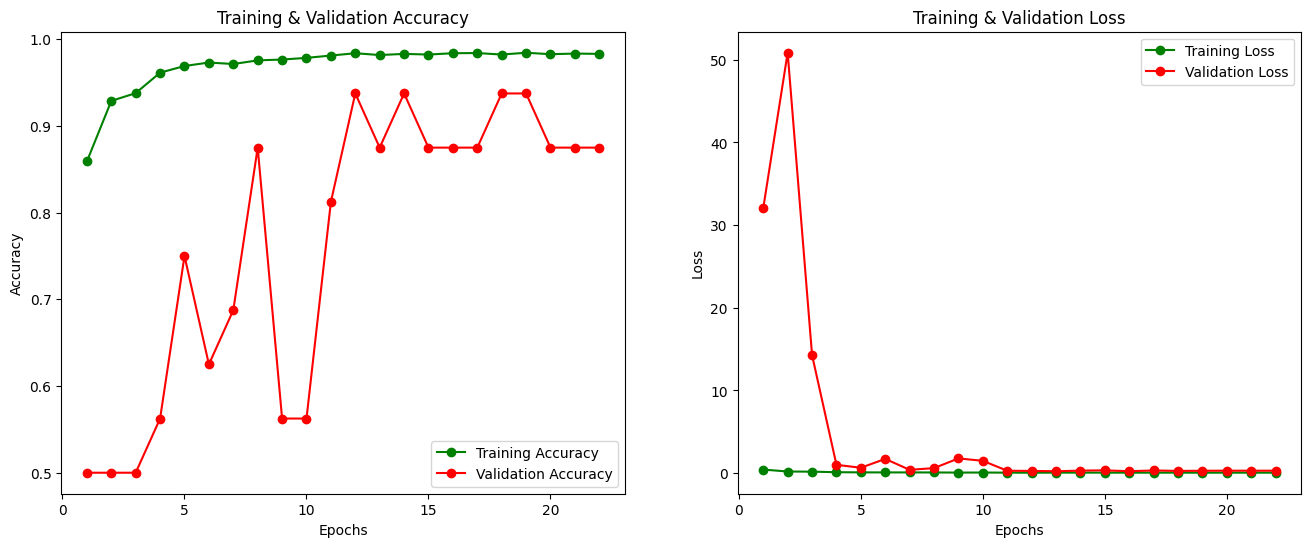

In [17]:
# Graficar Accuracy y Loss
def plotTrainingHistory(history):
    
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(16,6))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, train_acc, 'go-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, 'g-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Main
def main():
    print("Graficando Accuracy y Loss del entrenamiento...")
    plotTrainingHistory(history)

main()

# Evaluacion del modelo con datos de Test

Evaluando modelo con datos de prueba...
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 625ms/step - accuracy: 0.8783 - loss: 0.6103
Loss del modelo: 0.3909
Accuracy del modelo: 91.03%
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step

Reporte de clasificación:
              precision    recall  f1-score   support

   PNEUMONIA       0.93      0.82      0.87       234
      NORMAL       0.90      0.96      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



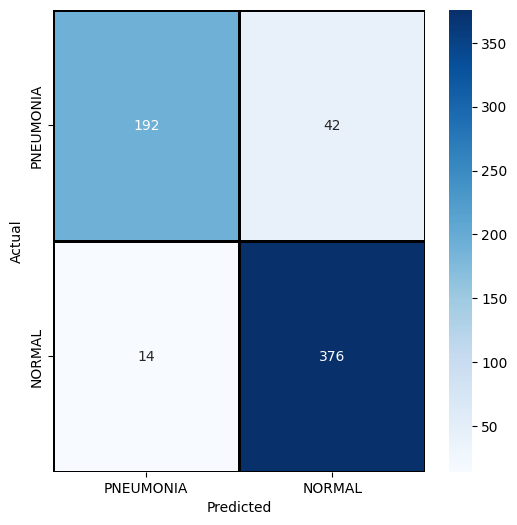

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluacion del modelo
def evaluateModel(model, testGen):
    print("Evaluando modelo con datos de prueba...")
    loss, acc = model.evaluate(testGen)
    print(f"Loss del modelo: {loss:.4f}")
    print(f"Accuracy del modelo: {acc*100:.2f}%")
    return loss, acc


# Predicciones
def getPredictions(model, testGen):
    # Predecir clases
    testGen.reset()
    preds = model.predict(testGen)
    preds_classes = (preds > 0.5).astype(int).reshape(-1)
    return preds_classes

def showClassificationReport(y_true, y_pred, labels):
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=labels))

def showConfusionMatrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linecolor='black', linewidth=1)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Maim
def main():
    labels = ["PNEUMONIA", "NORMAL"]

    # Evaluación
    evaluateModel(model, testGen)

    # Predicciones
    y_true = testGen.classes
    y_pred = getPredictions(model, testGen)

    # Reporte
    showClassificationReport(y_true, y_pred, labels)
    showConfusionMatrix(y_true, y_pred, labels)

main()